In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



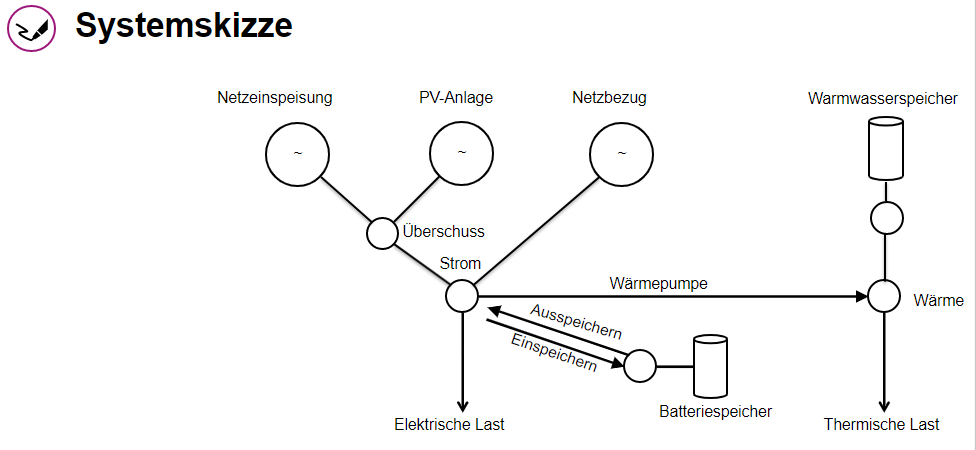

In [2]:
# Systemskizze für das Referenzmodell -> Bestimmen welcher Autarkiegrad möglich ist und schauen zu welchen Konditionen überhaupt
# Auch hier können bereits Parameter verändert werden
# Sensivitätsanalyse/ Strompreis abhängigkeit/ größe des Speichers im Verhältnis zum Investiotionslimit etc.pp

In [3]:
#csv-Datei importieren
csv_datei = "Modellierung_SoSe23.csv"
df_data = pd.read_csv(csv_datei, sep=';', decimal = ',')
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34
...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12


In [4]:
# Bezeichnung der einzelnen Spalten

elektrische_last = df_data['Verbrauch ']
pv_ertrag        = df_data['PV-Ertrag']
thermische_last  = df_data['Thermische Last ']
Temeperatur      = df_data['Außentemperatur']


In [5]:
# Berechnung des COPs der Wärmepumpe/ Daten vom Prof.

tabelle_x = [-15, -7, 2, 7, 10, 12, 20, 25, 30, 35]
cop_y = [1.7, 2.3, 2.6, 3, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]

df_data['COP_Tabelle']=np.interp(df_data['Außentemperatur'], 
                                             tabelle_x, cop_y)
wp_el_p_nom = 12.5 #kW
elektr_leistung_y = [14.58, 15.54, 16.7, 18.56, 18.79, 18.87, 19.05, 19.13, 19.36, 19.46]

df_data['WP_p_max_pu'] = np.interp(df_data['Außentemperatur'], 
                                     tabelle_x, elektr_leistung_y)/wp_el_p_nom
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur,COP_Tabelle,WP_p_max_pu
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70,3.235000,1.505440
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77,3.238500,1.505664
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55,3.227500,1.504960
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44,3.222000,1.504608
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34,3.217000,1.504288
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83,2.561000,1.323936
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51,2.550333,1.320636
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20,2.540000,1.317440
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12,2.529333,1.314140


In [6]:
WP_p_max_pu      = df_data['WP_p_max_pu']

#Basissystem
pv_p_nom = 10 # in kWp 
pv_p_pu = pv_ertrag/pv_p_nom

#Annahmen für das Ref-Netzwerke

#Marginale Kosten
strompreis_bezug = 0.40                            
strompreis_einspeisung = -0.08
gas_preis = 0.158

#Kapitalkosten pro Jahr pro kW
kapital_kosten_batteriespeicher = 892/12.5              #892€/kWh auf 12.5 Jahre
kapital_kosten_warmwasserspeicher = 53.32/20            #Preis(1965€)/36,85kWh (800l)/ Lebensdauer sind 20 Jahre
kapital_kosten_wp = (25000 / 7.5) / 25
kapital_kosten_pv = (1300*10)/20                        #10kWp Anlage ink. WR für 20000€ auf 20 Jahre

#Wirkungsgrade der Komponenten
wirkungsgrad_batteriespeicher_laden = 0.88        
wirkungsgrad_batteriespeicher_entladen = 0.88           #Wirkungsgrad von wurzel(77%)
selbstentlade_verluste_bs = 0.07
selbstentlade_verluste_ps = 0.08

In [7]:
summe = df_data['COP_Tabelle'].sum()

anzahl = len(df_data['COP_Tabelle'])

durchschnitt = summe/anzahl 

print(durchschnitt)

3.1461300646879753


In [21]:
network = pypsa.Network()
network.set_snapshots(df_data.index)


#Hinzufügung Bus
network.add('Bus', name = 'strom')
network.add('Bus', name = 'batterie')
network.add('Bus', name = 'ueberschuss')
network.add('Bus', name = 'waerme')

#Hinzufügung der Lasten
network.add('Load', name = 'elektrischeLast',bus = 'strom' , p_set  = elektrische_last)
network.add('Load', name = 'thermischelast', bus = 'waerme' , p_set = thermische_last)

#Hinzufügung der Generatoren
network.add('Generator', name = 'PV',              bus = 'ueberschuss', p_nom = pv_p_nom, p_max_pu = pv_p_pu, capital_cost = kapital_kosten_pv)
network.add('Generator', name = 'Netzeinspeisung', bus = 'ueberschuss', marginal_cost = strompreis_einspeisung, sign = -1, p_nom_extendable = True)
network.add('Generator', name = 'Netzbezug',       bus = 'strom', marginal_cost = strompreis_bezug, p_nom = elektrische_last.max())

#Hinzufügung der Speicher
network.add('Store', name = 'battriespeicher',  bus = 'batterie', e_nom_extendable = True, capital_cost = kapital_kosten_batteriespeicher, standing_loss = selbstentlade_verluste_bs, e_cyclic = True)
network.add('Store', name= 'warmwasserspeicher', bus= 'waerme', e_nom_extendable = True ,capital_cost= kapital_kosten_warmwasserspeicher, standing_loss= selbstentlade_verluste_ps)

#Hinzufügung der Links
network.add('Link', name = 'Einspeichern',   bus0 = 'strom',       bus1    = 'batterie', p_nom_extendable = True,  efficiency   = wirkungsgrad_batteriespeicher_laden)
network.add('Link', name = 'Ausspeichern',   bus0 = 'batterie',    bus1    = 'strom',    p_nom_extendable = True, efficiency = wirkungsgrad_batteriespeicher_entladen)
network.add('Link', name = 'eigenverbrauch', bus0 = 'ueberschuss', bus1    = 'strom',    p_nom_extendable = True)
network.add('Link', name = 'waermepumpe',    bus0 = 'strom',       bus1    = 'waerme',   p_nom_extendable = True, efficiency = df_data['COP_Tabelle'], capital_cost= kapital_kosten_wp)

In [22]:
network.optimize(solver_name = 'gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.92it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-1wli5_x9.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x8c6b5da8
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 7.32e+02
Solver model: available
Solver message: 2



('ok', 'optimal')

<Axes: xlabel='snapshot'>

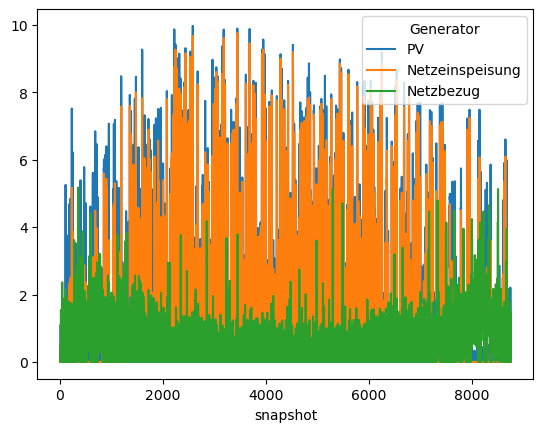

In [23]:
network.generators_t.p.plot()

<Axes: xlabel='snapshot'>

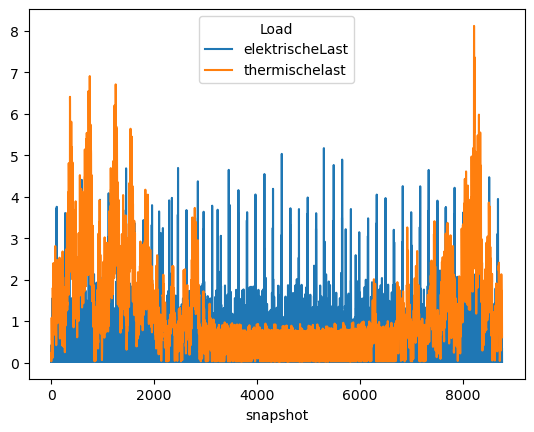

In [24]:
network.loads_t.p.plot()

In [25]:
network.generators_t.p.sum()

Generator
PV                 11581.694080
Netzeinspeisung     8117.976945
Netzbezug           3663.938377
dtype: float64

In [26]:
network.stores.e_nom_opt

Store
battriespeicher        0.000000
warmwasserspeicher    16.549765
Name: e_nom_opt, dtype: float64

array([<Axes: xlabel='snapshot'>, <Axes: xlabel='snapshot'>,
       <Axes: xlabel='snapshot'>], dtype=object)

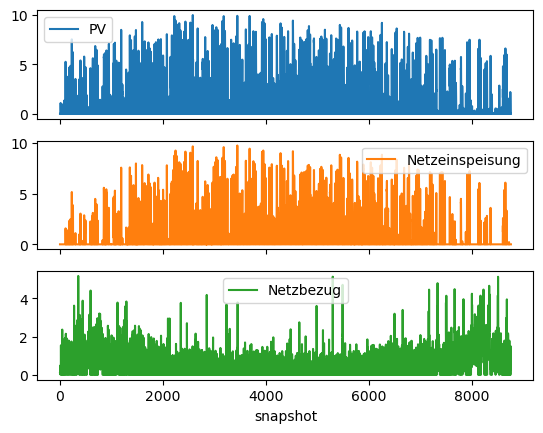

In [27]:
#Darstellung der Generatoren-Jahreslinie
network.generators_t.p.plot(subplots=True)

array([<Axes: xlabel='snapshot'>, <Axes: xlabel='snapshot'>], dtype=object)

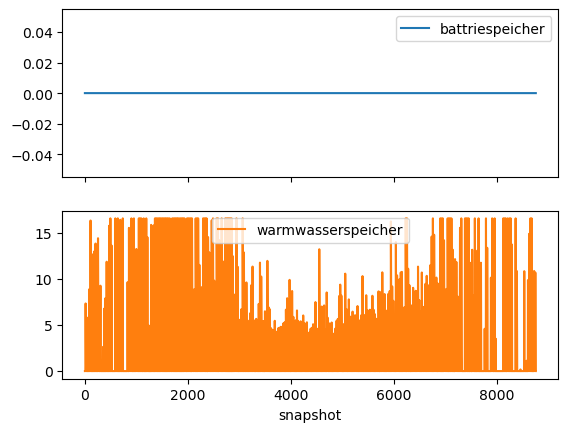

In [28]:
#Darstellung der Generatoren-Jahreslinie
network.stores_t.e.plot(subplots= True)

In [29]:
network.links.p_nom_opt.waermepumpe

2.338210333506179

In [30]:
#Definieren der zweiten Auswertungsfunktion (Wärmepumpe) ohne Sensitivitäsanaly

def auswertungsfunktion(network, sensitivity_variable = 0): 
    
    #Funktion der laufenden kosten
    
    #Funktion der laufende Kosten
    laufende_kosten_generators = (network.generators_t.p.Netzbezug * network.generators.marginal_cost.Netzbezug  +
                                       network.generators_t.p.PV * network.generators.marginal_cost.PV).sum()
    #Funktion für Investitionskosten
    kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()
    kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
    kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
    kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )
    
    #Gesamtkosten pro Jahr
    total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
    + kapital_kosten_stores + kapital_kosten_links) 
    
       
    #Einspeisevergütung (separat betrachtet von Gesamtkosten)
    einspeise_ertrag = (network.generators_t.p.Netzeinspeisung).sum()*strompreis_einspeisung *-1
    
    
    #Jährliche Einsparung der marginalen Kosten
    bezug_ursprung = (network.loads_t.p.elektrischeLast * network.generators.marginal_cost.Netzbezug + 
                      network.loads_t.p.thermischelast * gas_preis).sum()
    einsparung = bezug_ursprung - laufende_kosten_generators 
    
    #Armotisation
    Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) + (kapital_kosten_links *20)
    Amortisation = Anschaffungskosten/einsparung 
    
    
    #relevante Ausgabewerte
    netzbezug_summe = (network.generators_t.p.Netzbezug).sum()
    netzeinspeisung_summe= (network.generators_t.p.Netzeinspeisung).sum()
    pv_ertrag_summe = (network.generators_t.p.PV).sum()
    einspeicherung_summe = (network.links_t.p0.Einspeichern).sum()
    ausspeicherung_summe = (network.links_t.p0.Ausspeichern).sum()
    Kapazität_Batterie = (network.stores.e_nom_opt.battriespeicher)
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.warmwasserspeicher*36.85)
    Leistung_wp = (network.links.p_nom_opt.waermepumpe)
    
    
    
    #Werte in Ergebnistabelle auflisten
    results =pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                         pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                         pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                         pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                         pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                         pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                         pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                         pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                         pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                         pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                         pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                         pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                         pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität l']),
                         pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                         pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                         axis = 1)
    

               
    return results

In [31]:
result = auswertungsfunktion(network)
result

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität l,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
0,7881.785796,1479.285615,1025.902746,2505.188361,6855.88305,649.438156,96.906836,3663.938377,8117.976945,11581.69408,0.0,0.0,609.858824,0.0,2.33821


In [32]:
#Ausführung des Standardsnetzwerks
network.optimize(solver_name = 'gurobi')
results = auswertungsfunktion(network, 1)                           


# Call up of the function results, clearing of the results DF
results.drop(results.index, inplace=True)  
results.index.name = 'Strompreis von 0,28 €/kWh bis 1,48 €kWh'


#Preisvariation und Ausgabe der neuen Ergebnisse
for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.1)): 
    print(strompreis_bezug)
    network.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 
    network.optimize(solver_name = 'gurobi')
    results= results.append(auswertungsfunktion(network, strompreis_bezug )) 

network.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 34.96it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-tzh1xwbr.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x8c6b5da8
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.16s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 7.32e+02
Solver model: available
Solver message: 2



1.3799999999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.19it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-k06rmxv2.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0xedab2dfc
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.16s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 3.88e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.2799999999999998


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.98it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-d56znj2l.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x5b625d77
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 3.63e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.1799999999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.28it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-i6gv_8pe.lp
Reading time = 0.32 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x44dd7370
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.18s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 3.37e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.0799999999999998


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.35it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-8gqo2x7p.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x8c7039cf
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 3.11e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.9799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.95it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-g9dq0wsy.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0xf1598bd5
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 2.85e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.8799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.67it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-90j_0_x7.lp
Reading time = 0.33 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0xc98284d9
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.17s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 2.59e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.7799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 33.67it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-4rrxhbrd.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x232b78d2
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.16s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 2.32e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.6799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.80it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ejmipv5v.lp
Reading time = 0.32 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0xda9635a1
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.17s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 2.04e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.58


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.15it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-lhinltsi.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x4249a708
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 1.75e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.48


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.17it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-t4csukmj.lp
Reading time = 0.31 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0xaf6a01a0
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 1.44e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.38


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 34.86it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-n7pinzld.lp
Reading time = 0.32 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x145f325c
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.16s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 1.09e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.28


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.85it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-kcu80r6p.lp
Reading time = 0.32 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x8c6b5da8
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.16s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 7.32e+02
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_37456\1490851207.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [33]:
#Ausgabe der Sensitivitätsanalyse des zweiten Netzwerks
results

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität l,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
1.38,10827.055151,2663.286214,3476.303799,6139.590013,7350.751352,447.441320,57.598101,2519.060724,5593.016502,11581.69408,2036.442103,1167.566285,1237.667825,6.193236,2.394450
1.28,10581.128092,2546.834179,3262.355683,5809.189863,7318.772409,454.732083,59.948781,2548.715378,5684.151040,11581.69408,1964.082925,1138.428896,1209.621474,5.830320,2.364059
1.18,10330.751310,2446.561253,3032.228460,5478.789712,7298.522850,460.317932,62.210337,2569.685135,5753.974153,11581.69408,1916.079976,1119.697822,1189.647035,5.618105,2.336603
1.08,10079.531311,2343.320313,2805.069249,5148.389562,7274.462062,467.205401,64.730758,2597.286342,5840.067516,11581.69408,1852.735887,1092.243119,1155.982384,5.339783,2.323372
0.98,9825.387055,2242.966165,2575.023247,4817.989412,7250.363808,474.137176,67.402694,2627.574742,5926.714695,11581.69408,1781.388019,1060.313530,1134.908638,5.038143,2.315507
0.88,9570.853616,2132.355387,2355.233874,4487.589262,7215.619742,484.671331,70.554079,2676.402130,6058.391641,11581.69408,1677.899241,1012.335053,1082.503178,4.632914,2.300241
0.78,9314.230475,2016.914333,2140.274779,4157.189112,7173.955696,498.546706,74.159749,2743.942024,6231.833826,11581.69408,1543.355642,946.364157,1004.947093,4.155172,2.285530
0.68,9052.070827,1901.721401,1925.067560,3826.788961,7127.003267,514.872524,78.139155,2830.981706,6435.906550,11581.69408,1366.586519,856.225248,947.803896,3.580301,2.272064
0.58,8786.026529,1779.934575,1716.454236,3496.388811,7069.572293,538.124577,82.829664,2959.403855,6726.557212,11581.69408,1115.278383,721.003971,888.808325,2.848550,2.264976
0.48,8522.884382,1605.126738,1560.861923,3165.988661,6962.022459,583.866294,90.529810,3251.795672,7298.328675,11581.69408,555.920782,383.167098,843.909980,1.364901,2.276763
